In [19]:
from neurodiffeq import diff
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq.conditions import IVP, DirichletBVP2D, IBVP1D, BundleDirichletBVP, NoCondition
from neurodiffeq.networks import FCNN, SinActv
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d  import Axes3D
import sys

In [ ]:
sys.path.append('/absolute/path/to/modified/matplotlib')

In [15]:
lamb = 1.0
m = 1.0

In [22]:
def pde_system(u, x, y):
    return [diff(u, x, order=2), diff(u, y, order=2), diff(diff(u,x),y) + lamb*lamb]

# conditions = [
#     DirichletBVP2D(
#         x_min=0, x_min_val=lambda y: torch.sin(np.pi*y),
#         x_max=1, x_max_val=lambda y: 0,                   
#         y_min=0, y_min_val=lambda x: 0,                   
#         y_max=1, y_max_val=lambda x: 0,                   
#     )
# ]

# conditions = [
#     DirichletBVP2D(
#         x_min=0, x_min_val=lambda y: m/lamb,
#         x_max=1, x_max_val=lambda y: 0,                   
#         y_min=0, y_min_val=lambda x: 0,                   
#         y_max=1, y_max_val=lambda x: 0,                   
#     )
# ]

# conditions = [
#     IBVP1D(
#         x_min=0, x_min_val = m/lamb
#     )
# ]

# conditions = [
#     BundleDirichletBVP(
#         t_0=0, u_0=m/lamb
#         t_1=0
#     )
# ]
conditions = [
     NoCondition()   
]
nets = [FCNN(n_input_units=2, n_output_units=1, hidden_units=(512,))]

solver = Solver2D(pde_system, conditions, xy_min=(0, 0), xy_max=(1, 1), nets=nets)
solver.fit(max_epochs=2)
solution = solver.get_solution()

TypeError: BundleDirichletBVP.__init__() missing 2 required positional arguments: 't_1' and 'u_1'

In [23]:
x = np.linspace(0.0, 1.0, 101)
y = np.linspace(0.0, 1.0, 101)
X, Y = np.meshgrid(x, y)
sol_net = solution(X, Y, to_numpy=True)

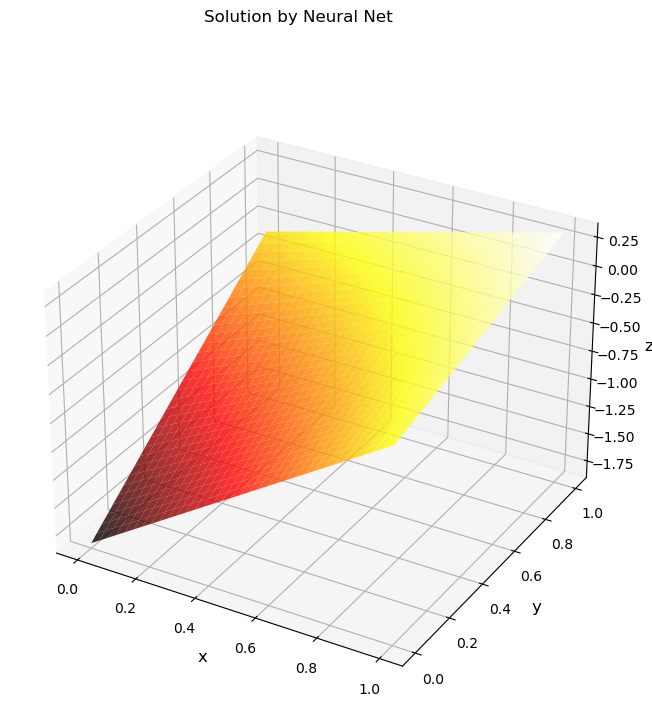

In [24]:
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, sol_net, cmap='hot', alpha=0.8)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
fig.suptitle('Solution by Neural Net')
plt.show()

In [27]:
x1 = np.linspace(0.0, 1.0, 101)
x2 = np.linspace(0.0, 1.0, 101)
X1, X2 = np.meshgrid(x1, x2)
z_an = -lamb*lamb*X1*X2 + m/lamb

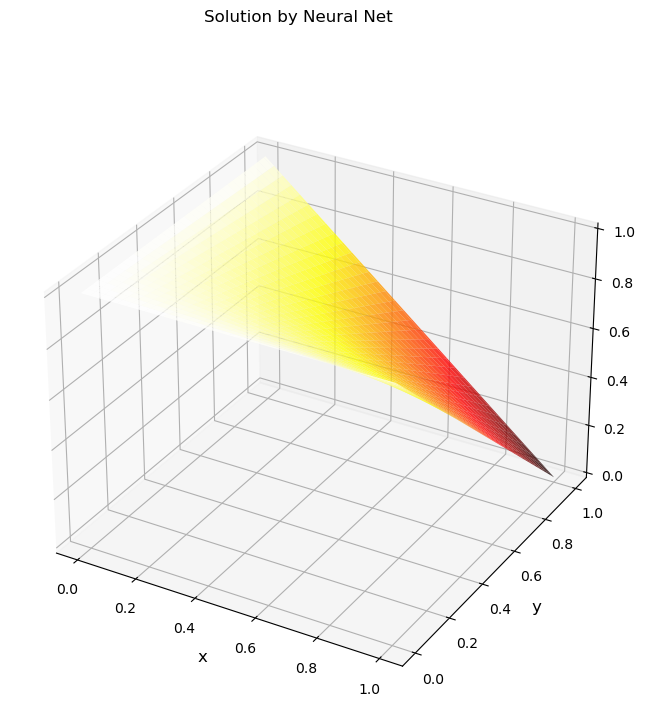

In [28]:
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, z_an, cmap='hot', alpha=0.8)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
fig.suptitle('Solution by Neural Net')
plt.show()

In [29]:
def parameterize(self, output_tensor, t):
        r"""Re-parameterizes outputs such that the Dirichlet/Neumann condition is satisfied.

        - For Dirichlet condition, the re-parameterization is
          :math:`\displaystyle u(t) = u_0 + \left(1 - e^{-(t-t_0)}\right) \mathrm{ANN}(t)`
          where :math:`\mathrm{ANN}` is the neural network.
        - For Neumann condition, the re-parameterization is
          :math:`\displaystyle u(t) = u_0 + (t-t_0) u'_0 + \left(1 - e^{-(t-t_0)}\right)^2 \mathrm{ANN}(t)`
          where :math:`\mathrm{ANN}` is the neural network.

        :param output_tensor: Output of the neural network.
        :type output_tensor: `torch.Tensor`
        :param t: Input to the neural network; i.e., sampled time-points; i.e., independent variables.
        :type t: `torch.Tensor`
        :return: The re-parameterized output of the network.
        :rtype: `torch.Tensor`
        """
        if self.u_0_prime is None:
            return self.u_0 + (1 - torch.exp(-t + self.t_0)) * output_tensor
        else:
            return self.u_0 + (t - self.t_0) * self.u_0_prime + ((1 - torch.exp(-t + self.t_0)) ** 2) * output_tensor


